# Iris Plant Species Classification

## Analyze the data using the same techniques as for the last assignment.
Decide for yourself which and how to use the specific commands. Answer
the following questions in the report and include figures supporting your
answers:

### Which classes exist? Are they (roughly) balanced?

In [6]:
import utils
import pandas as pd
import matplotlib as plt
from sklearn import preprocessing

plt.rc('font', size=16)

df = pd.read_csv('iris.csv')
utils.ratio(df, 'Name')

,samples,ratio
Name,,
Iris-setosa,50,1.0
Iris-versicolor,50,1.0
Iris-virginica,50,1.0


Classes: Iris-setosa, Iris-versicolor, Iris-virginica
They are perfectly balanced.

### Which noteworthy trends of features and relations between features as well as features and Classes do you see?

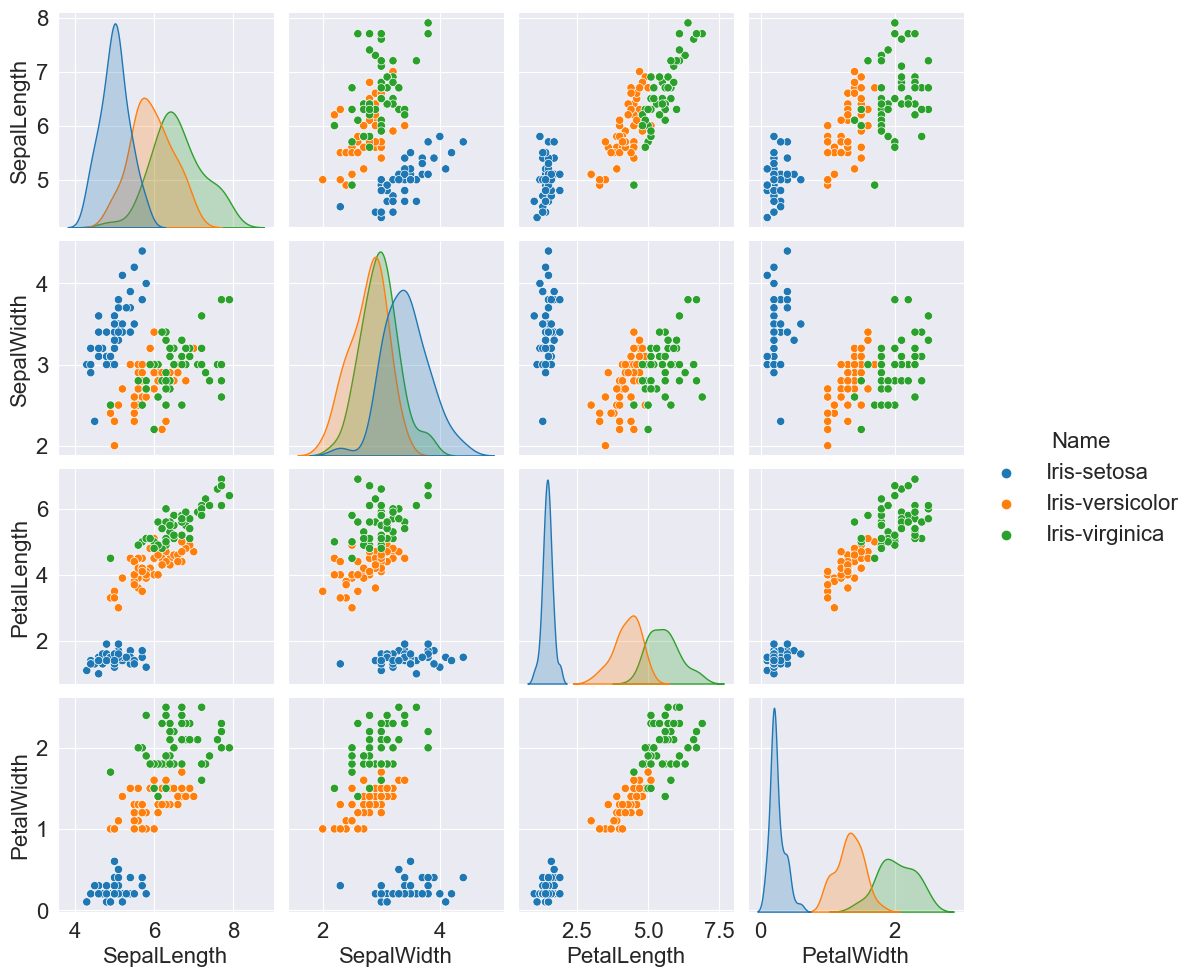

In [2]:
import seaborn as sns

sns.pairplot(df, hue='Name')

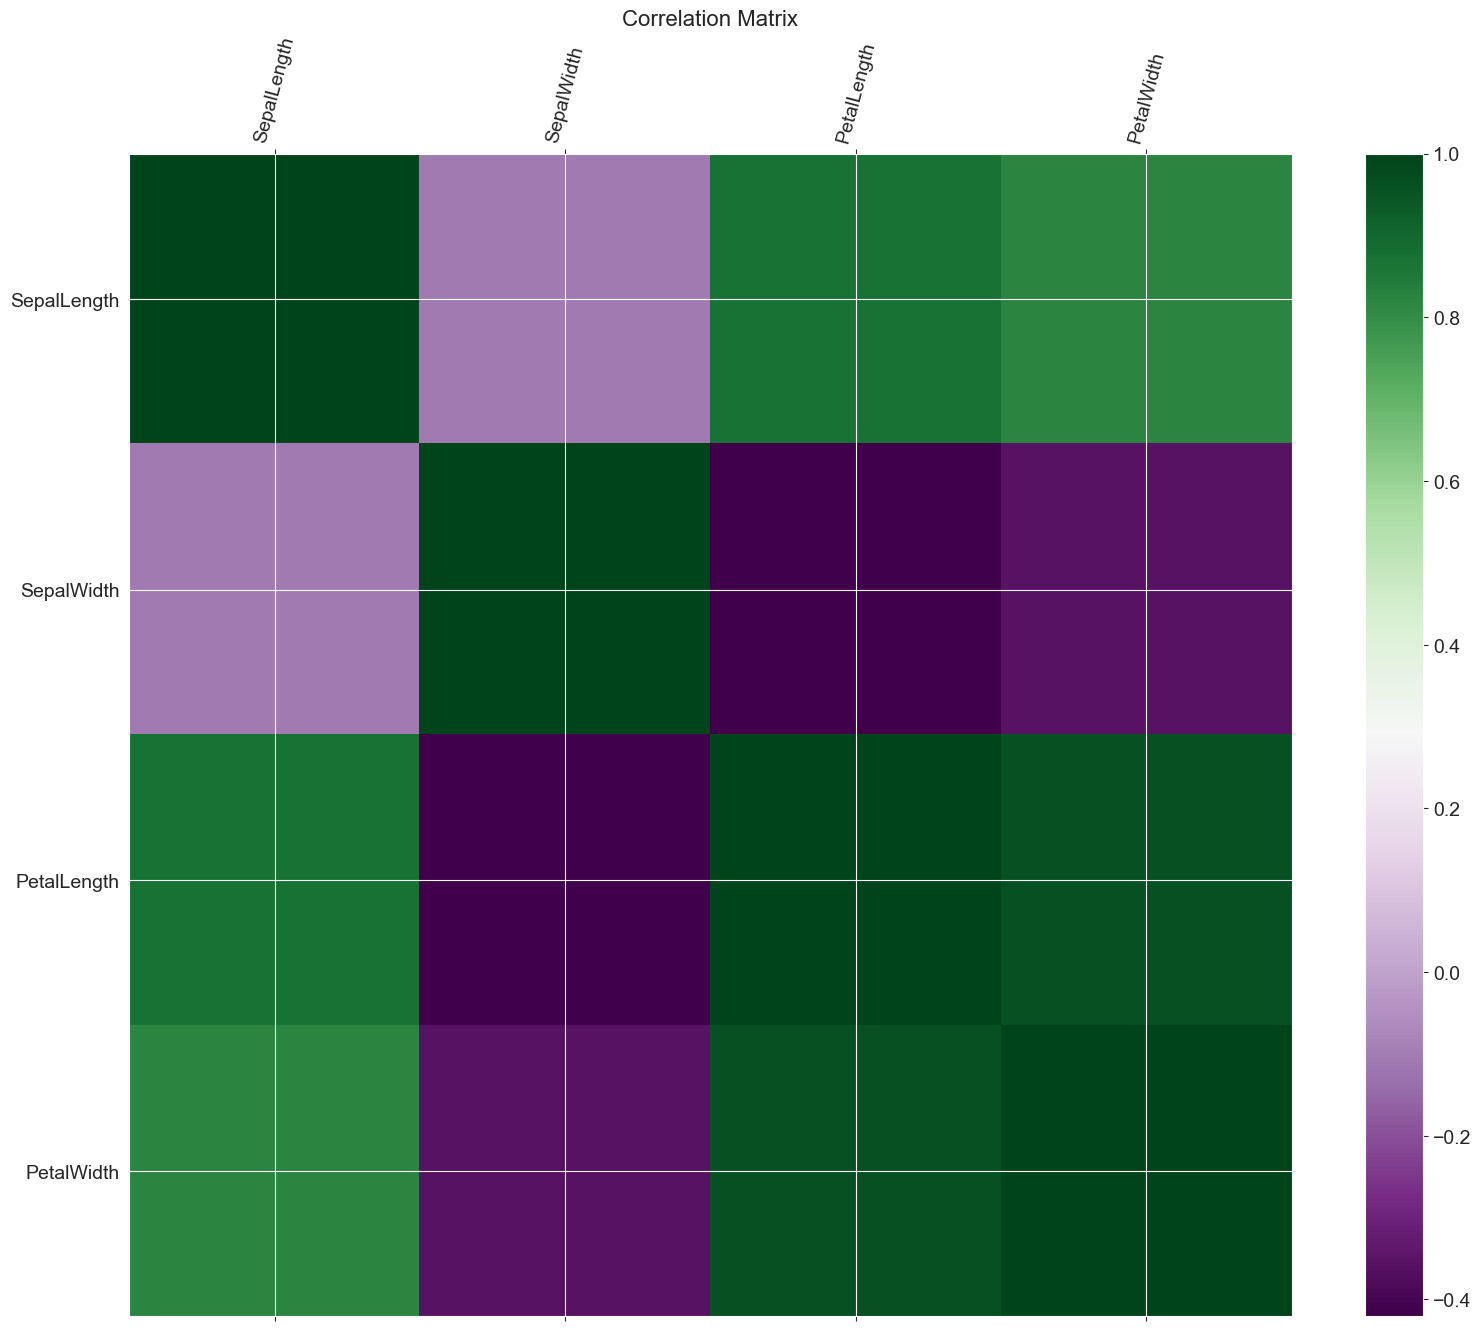

In [3]:
utils.piggy_matrix(df)

PetalLength       AxesSubplot(0.125,0.11;0.168478x0.77)
PetalWidth     AxesSubplot(0.327174,0.11;0.168478x0.77)
SepalLength    AxesSubplot(0.529348,0.11;0.168478x0.77)
SepalWidth     AxesSubplot(0.731522,0.11;0.168478x0.77)
dtype: object

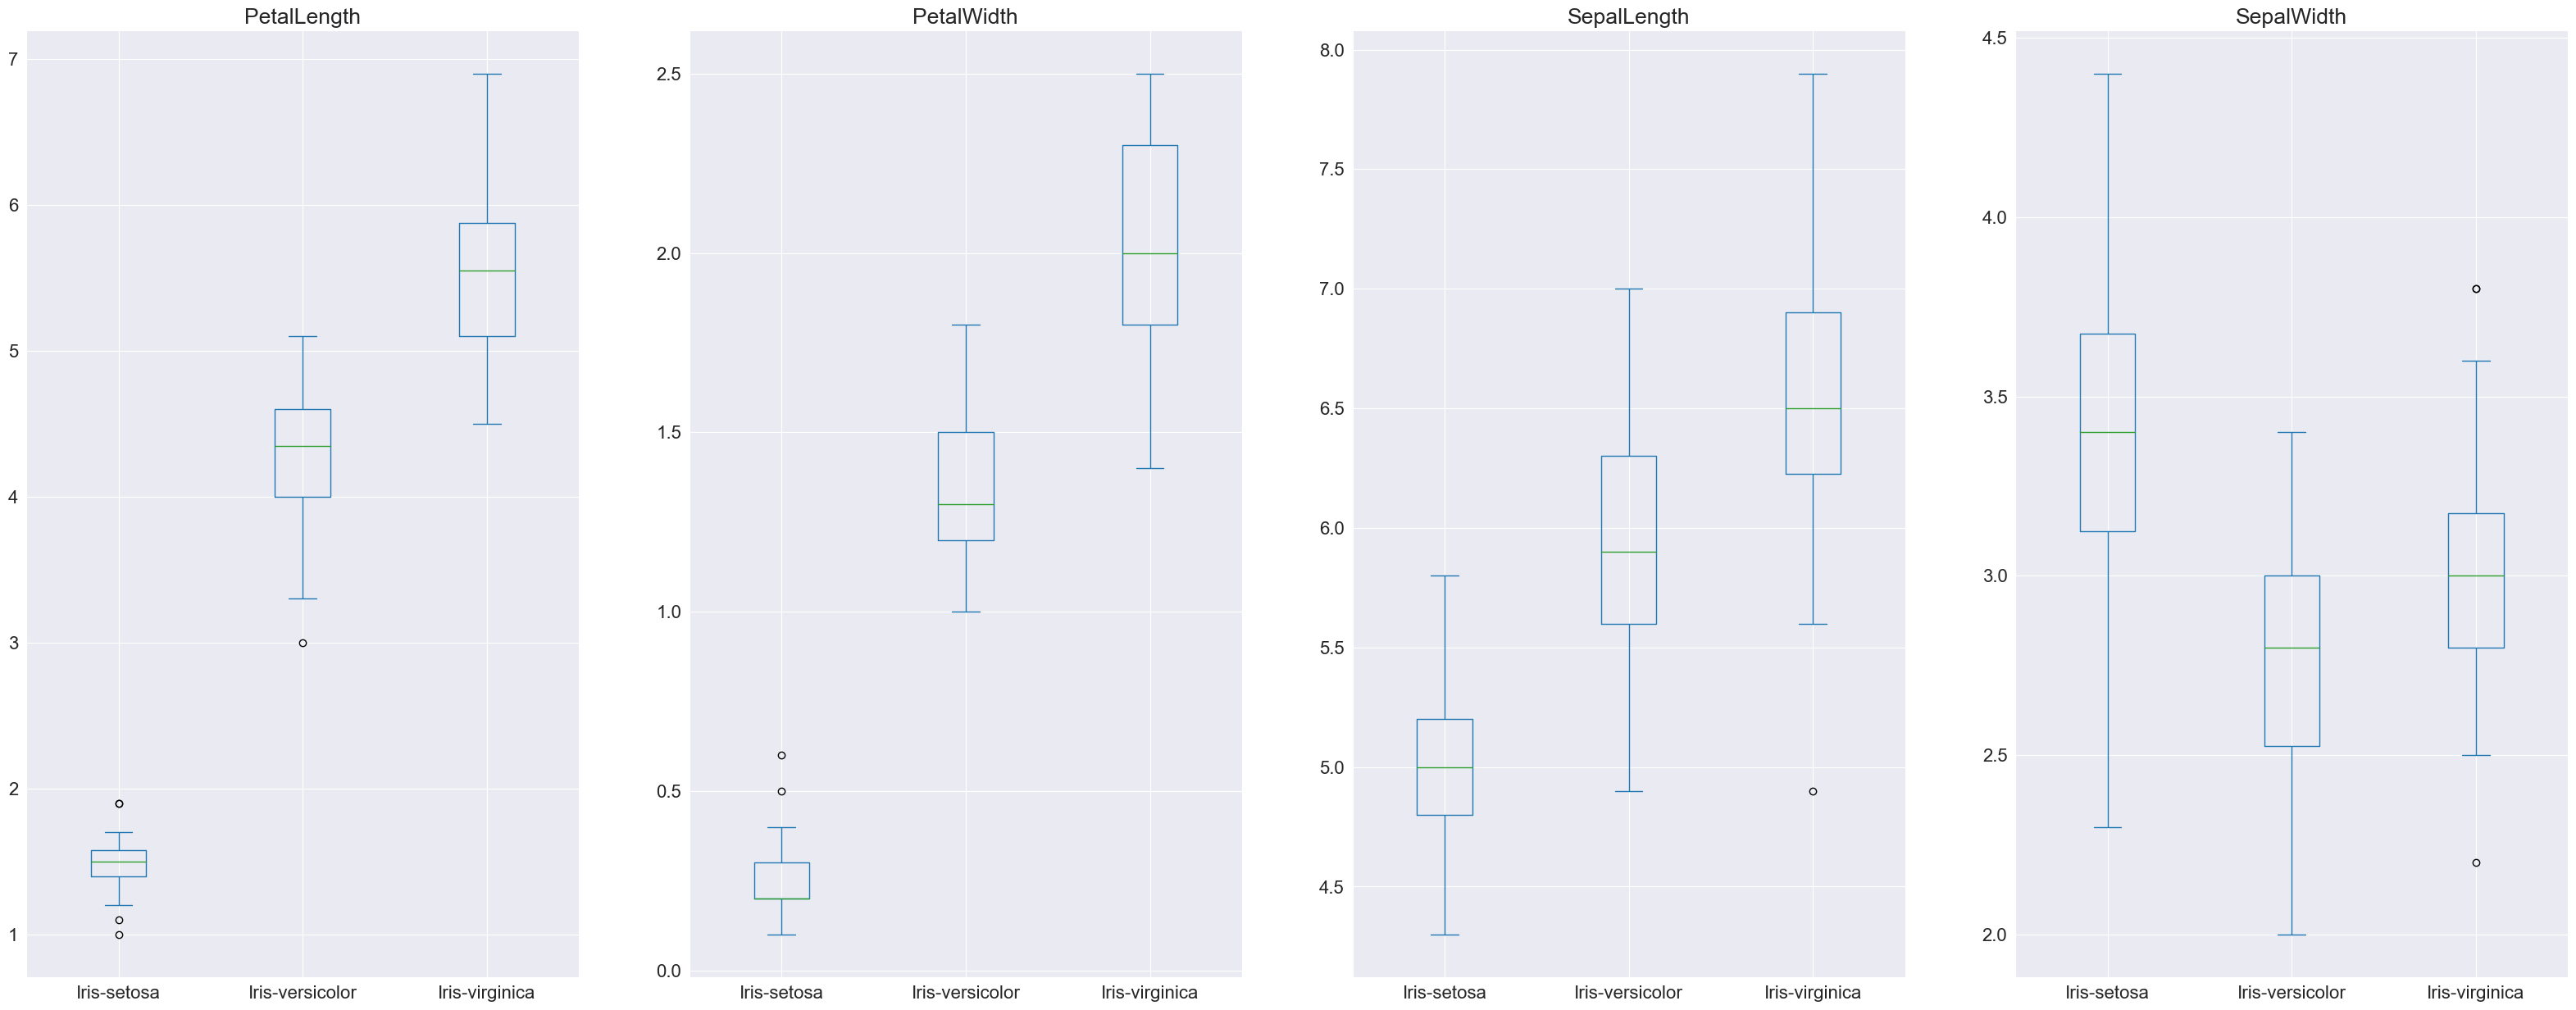

In [5]:
df.plot.box(by='Name',figsize=(40, 15), fontsize=16)

PetalLength and PetalWidth correlate well.
PetalLength and SepalWidth correlate negatively. (see correlation matrix above)
PetalLength and PetalWidth are well segmented and can be used to distinguish.

### If you would need to distinguish the classes with those features, which features would you choose, any why?

PetalLength and PetalWidth because they don't overlap significantly. (see boxplot above)


## In order to classify the three different Iris plant species, set up your first
ML toolchain including the following steps:

### Data and Feature Preprocessing (if necessary and applicable)
* Are there any outliers in the data which might need to be removed?
* Are there any missing values which need to be taken care of?
* Do you need to apply any feature preprocessing steps? (e.g Normalization, Feature Deletion/Reduction/Addition)
* Are there any categorical features that need to be transformed so that it can be used for classification task?
* Do you think it makes sense to derive any more features from the given ones? Why/why not?

In [8]:
df.quantile(0.99)

C:\Users\Sleya\AppData\Local\Temp\ipykernel_17080\3007300547.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.quantile(0.99)


SepalLength    7.700
SepalWidth     4.151
PetalLength    6.700
PetalWidth     2.500
Name: 0.99, dtype: float64

* Split up the dataset into a training and a separate held back test set in a clever way
    * Why is such a train/test split important?
    * Which train/test split percentage do you choose and why?
    * Think about how can you make sure to include samples from all three classes in both datasets and why this is important.
* Train different classification models to distinguish between the three Iris Plant Species:
    * Use the following models: k Nearest Neighbour, Decision Tree, Support Vector Machine
* Use different hyperparameter settings for each model and explain why and how you chose them
* Use an appropriate cross-validation setup for the training
* Estimate the models’ performances on the held back test set:
* Compare the models with their hyperparameter settings with two different error/performance measures * Why did you chose the specific error/performance measures? * What do they tell you?
    * Which model performs best with which hyperparameter settings and why do you think it does that way?
* Explain which model you would use in deployment and why